<a href="https://colab.research.google.com/github/DevanshRaheja/Visionlab_CV_Assignment/blob/main/Visionlab_CV_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Git and clone the DINO repository
!git clone https://github.com/IDEA-Research/DINO.git
%cd DINO

# Install the required dependencies from the repository
!pip install -r requirements.txt

# Install other dependencies for visualization and data handling
!pip install opencv-python-headless pycocotools matplotlib

Cloning into 'DINO'...
remote: Enumerating objects: 442, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 442 (delta 136), reused 96 (delta 96), pack-reused 251 (from 1)
Receiving objects: 100% (442/442), 13.43 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/DINO
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-install-k916yp7g/pycocotools_a268fb538c1044d2aa22d6ab2e0958ee
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-install-k916yp7g/pycocotools_a268fb538c1044d2aa22d6ab2e0958ee
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-k916yp7g/panopticapi_c9f9970edfb940c4a6daf5c6bdcee740
  Running command git clone --filter=blob:none --quiet https://github

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Assuming dataset is in a folder 'dataset/' with subfolders 'images/' and 'annotations/'
data_dir = '/content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset'
images_dir = os.path.join(data_dir, 'Pedestrian_Dataset')
annotations_file = os.path.join(data_dir, 'pedestrian_annotations', 'pedestrian_annotations.json')

# Create train/val directories
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Split into train and validation sets (80-20 split)
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

# Move images to train/val folders
for img in train_images:
    shutil.copy(os.path.join(images_dir, img), train_dir)

for img in val_images:
    shutil.copy(os.path.join(images_dir, img), val_dir)


In [ ]:
# Similarly, adjust your annotations JSON file for the split

import json
import os

# Paths to the original annotations and the training/validation splits
annotations_file = '/content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset/pedestrian_annotations/pedestrian_annotations.json'
train_images_dir = '/content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset/train'
val_images_dir = '/content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset/val'

# Load the original COCO annotations
with open(annotations_file, 'r') as f:
    coco_data = json.load(f)

# Collect image filenames for train and val splits
train_images = set(os.listdir(train_images_dir))
val_images = set(os.listdir(val_images_dir))

def filter_annotations(images_set, coco_data):
    # Filter images
    filtered_images = [img for img in coco_data['images'] if img['file_name'] in images_set]
    image_ids = {img['id'] for img in filtered_images}

    # Filter annotations that correspond to the filtered images
    filtered_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]

    # Keep other COCO data like categories unchanged
    filtered_data = {
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': coco_data['categories']
    }

    return filtered_data

# Create training and validation annotations
train_annotations = filter_annotations(train_images, coco_data)
val_annotations = filter_annotations(val_images, coco_data)

train_annotations_file = '/content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset/pedestrian_annotations/train_annotations.json'
val_annotations_file = '/content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset/pedestrian_annotations/val_annotations.json'

# Save the training annotations
with open(train_annotations_file, 'w') as f:
    json.dump(train_annotations, f)

# Save the validation annotations
with open(val_annotations_file, 'w') as f:
    json.dump(val_annotations, f)

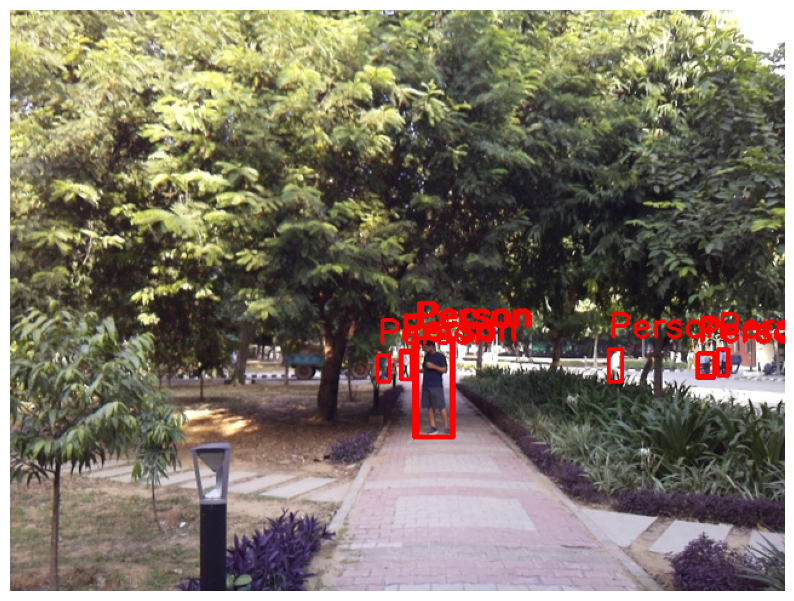

In [3]:
import matplotlib.pyplot as plt
import cv2
import json
import os

# Path to the dataset and annotations
annotations_path = '/content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset/pedestrian_annotations/train_annotations.json'
image_dir = '/content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset/train'

# Load the COCO annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Create a dictionary for easier access to annotations by image_id
annotations_by_image_id = {}
for ann in annotations['annotations']:
    image_id = ann['image_id']
    if image_id not in annotations_by_image_id:
        annotations_by_image_id[image_id] = []
    annotations_by_image_id[image_id].append(ann)

# Create a dictionary to map image ids to file names
image_id_to_filename = {img['id']: img['file_name'] for img in annotations['images']}

# Helper function to visualize bounding boxes on a single image
def visualize_bboxes(image_id, annotations, image_dir):
    # Get the image file name from image_id
    image_file = image_id_to_filename[image_id]

    # Load the image
    image_path = os.path.join(image_dir, image_file)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw the bounding boxes for this image
    for ann in annotations_by_image_id[image_id]:
        bbox = ann['bbox']
        x, y, w, h = map(int, bbox)
        category_id = ann['category_id']

        # Optionally, get the category name (assuming category 1 is 'person')
        if category_id == 1:
            label = 'Person'
        else:
            label = 'Unknown'

        # Draw the rectangle and label
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue box
        img = cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Test visualization with one image
# Use any image id from your annotations file
test_image_id = annotations['images'][5]['id']  # Example, pick any image ID

visualize_bboxes(test_image_id, annotations, image_dir)


In [5]:
!mkdir checkpoint

In [6]:
!cp /content/drive/MyDrive/Visionlab_Assignment/New_Checkpoint/checkpoint0011_4scale.pth /content/DINO/checkpoint/

In [7]:
!pip install yapf==0.31.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: yapf
    Found existing installation: yapf 0.40.2
    Uninstalling yapf-0.40.2:
      Successfully uninstalled yapf-0.40.2


In [9]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [ ]:
!apt-get update
!apt-get install cuda

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

In [ ]:
!apt-get install -y nvidia-driver-460

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cccl-12-6 cuda-command-line-tools-12-6 cuda-compiler-12-6 cuda-crt-12-6 cuda-cudart-12-6
  cuda-cudart-dev-12-6 cuda-cuobjdump-12-6 cuda-cupti-12-6 cuda-cupti-dev-12-6 cuda-cuxxfilt-12-6
  cuda-documentation-12-6 cuda-driver-dev-12-6 cuda-gdb-12-6 cuda-libraries-12-6
  cuda-libraries-dev-12-6 cuda-nsight-12-6 cuda-nsight-compute-12-6 cuda-nsight-systems-12-6
  cuda-nvcc-12-6 cuda-nvdisasm-12-6 cuda-nvml-dev-12-6 cuda-nvprof-12-6 cuda-nvprune-12-6
  cuda-nvrtc-12-6 cuda-nvrtc-dev-12-6 cuda-nvtx-12-6 cuda-nvvm-12-6 cuda-nvvp-12-6 cuda-opencl-12-6
  cuda-opencl-dev-12-6 cuda-profiler-api-12-6 cuda-sanitizer-12-6 cuda-toolkit-12-6
  cuda-toolkit-12-6-config-common cuda-tools-12-6 cuda-visual-tools-12-6 default-jre
  fonts-dejavu-extra gds-tools-12-6 libatk-wrapper-java libatk-wrapper-java-jni libcublas-12-6
 

In [10]:
!nvidia-smi

Mon Sep 23 06:40:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
print(torch.cuda.is_available())

False


In [11]:
!cd /content/DINO/models/dino/ops && bash make.sh

running build
running build_py
creating build
creating build/lib.linux-x86_64-cpython-310
creating build/lib.linux-x86_64-cpython-310/modules
copying modules/ms_deform_attn.py -> build/lib.linux-x86_64-cpython-310/modules
copying modules/__init__.py -> build/lib.linux-x86_64-cpython-310/modules
creating build/lib.linux-x86_64-cpython-310/functions
copying functions/__init__.py -> build/lib.linux-x86_64-cpython-310/functions
copying functions/ms_deform_attn_func.py -> build/lib.linux-x86_64-cpython-310/functions
running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:495: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:414: UserWarning: The detected CUDA version (12.2) has a minor version mismatch with the version that was used to compil

In [34]:
!bash scripts/DINO_eval.sh /content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset /content/DINO/checkpoint/checkpoint0011_4scale.pth

Not using distributed mode
Loading config file from config/DINO/DINO_4scale.py
[09/23 07:46:57.970]: git:
  sha: d84a491d41898b3befd8294d1cf2614661fc0953, status: has uncommited changes, branch: main

[09/23 07:46:57.970]: Command: main.py --output_dir logs/DINO/R50-MS4-%j -c config/DINO/DINO_4scale.py --coco_path /content/drive/MyDrive/Visionlab_Assignment/Ped_Dataset --eval --resume /content/DINO/checkpoint/checkpoint0011_4scale.pth --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0
[09/23 07:46:57.971]: Full config saved to logs/DINO/R50-MS4-%j/config_args_all.json
[09/23 07:46:57.971]: world size: 1
[09/23 07:46:57.971]: rank: 0
[09/23 07:46:57.971]: local_rank: 0
[09/23 07:46:57.971]: args: Namespace(config_file='config/DINO/DINO_4scale.py', options={'dn_scalar': 100, 'embed_init_tgt': True, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'use_ema': False, 'dn_box_noise_scale': 1.0}, dataset_file='coco', coco_path='/conte